In [1]:
import torch
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
from utils.vis import *
from utils.data import *
from model import PoseModel
from transform import *
from dataset import PlanktonDataset
import cPickle as pickle
import numpy as np
import glob
from scipy.spatial.distance import euclidean

%matplotlib inline

In [2]:
img_dir = '/data5/Plankton_wi18/rawcolor_db/images'
csv_filename = '/data5/lekevin/plankton/poseprediction/data2/data_{}.csv'

phases = ['train', 'valid', 'test']

# dataset_mean, dataset_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
normalize = Normalize([0.5, 0.5, 0.5], [1, 1, 1])

batch_size = 16

input_size = (384, 384)

_GPU = 1

data_transform = {
    'train': transforms.Compose([
        Rescale(input_size),
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        ToTensor(),
        normalize
    ]),
    'valid': transforms.Compose([
        Rescale(input_size),
        ToTensor(),
        normalize
    ]),
    'test': transforms.Compose([
        Rescale(input_size),
        ToTensor(),
        normalize
    ])
}
print 'Loading datasets ...'
datasets = {x: PlanktonDataset(csv_file=csv_filename.format(x),
                               img_dir=img_dir,
                               transform=data_transform[x])
            for x in phases}

dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size,
                             shuffle=False, num_workers=4)
               for x in phases}

dataset_sizes = {x: len(datasets[x]) for x in phases}

use_gpu = torch.cuda.is_available()

Loading datasets ...


In [3]:
def euclideanDistance(prediction, gtruthHead, gtruthTail):
    headEuclid, tailEuclid = [], []
    head, tail = 0, 1
    nSmpl = len(prediction)
    for i in range(nSmpl):
        headEuclid.append (euclidean (prediction[i][head], gtruthHead[i]))
        tailEuclid.append (euclidean (prediction[i][tail], gtruthTail[i]))
    headEuclid = np.asarray (headEuclid)
    tailEuclid = np.asarray (tailEuclid)
    histData = {'Head Distribution': headEuclid, 'Tail Distribution': tailEuclid}
    avgHeadEuclid = headEuclid.mean ()
    avgTailEuclid = tailEuclid.mean ()
    avgEuclid = np.array ((avgHeadEuclid, avgTailEuclid)).mean ()
    return {'Head Distance':avgHeadEuclid,
            'Tail Distance':avgTailEuclid,
            'Avg Distance':avgEuclid,
            'Distribution':histData}

def concatCoordinates(headX, headY, tailX, tailY):
    assert headX.shape == headY.shape and tailX.shape == tailY.shape
    headXY = np.column_stack ((headX, headY))
    tailXY = np.column_stack ((tailX, tailY))
    poseXY = np.stack([headX - tailX, headY - tailY], axis=1)
    return headXY, tailXY, poseXY

In [4]:
temp_predCoordinates = pickle.load(open('predPose.p', "rb"))
predCoordinates = np.asarray([np.fliplr(i) for i in temp_predCoordinates]) # (y,x) --> (x,y)

# taxLvl Datasets Order --> Specimen, Genus, Family, Order, Dataset
# Initialize pose & classes - Test Data
headX, headY = datasets['test'].data['head_x_rel'], datasets['test'].data['head_y_rel']
tailX, tailY =  datasets['test'].data['tail_x_rel'], datasets['test'].data['tail_y_rel']
gtruthHead, gtruthTail, poseTestSet = concatCoordinates(headX, headY, tailX, tailY)
testTaxLvlDatasets, testspecimenIDs = group_specimen2class(datasets['test'].data['images'])

# Initialize pose & classes - Train Data
headX, headY = datasets['train'].data['head_x_rel'], datasets['train'].data['head_y_rel']
tailX, tailY =  datasets['train'].data['tail_x_rel'], datasets['train'].data['tail_y_rel']
__, __, poseTrainSet = concatCoordinates(headX, headY, tailX, tailY)
trainTaxLvlDatasets, trainspecimenIDs = group_specimen2class(datasets['train'].data['images'])

# Entire Dataset Evaluation

In [17]:
classMetrics, classMetrics_idx = {}, {}
for cls in testTaxLvlDatasets['Dataset']:
    # Gather images of each class by their indices from dataset
    trainIdx = [i for i, spc in enumerate(trainspecimenIDs) if spc in trainTaxLvlDatasets['Dataset'][cls]]
    testIdx = [i for i, spc in enumerate(testspecimenIDs) if spc in testTaxLvlDatasets['Dataset'][cls]]

    # Compute metrics
    metrics = {}
    metrics['Euclid'] = euclideanDistance (predCoordinates[testIdx], gtruthHead[testIdx], gtruthTail[testIdx])
    metrics['PoseVar'] = pose_variability2(poseTrainSet[trainIdx], [trainspecimenIDs[i] for i in trainIdx])
    metrics['KLDiv'] = pose_diff2(poseTrainSet[trainIdx], [trainspecimenIDs[i] for i in trainIdx],
                                       poseTestSet[testIdx], [testspecimenIDs[i] for i in testIdx])
    classMetrics[cls] = metrics

Average Euclidian Distance:  0.10655394637052765


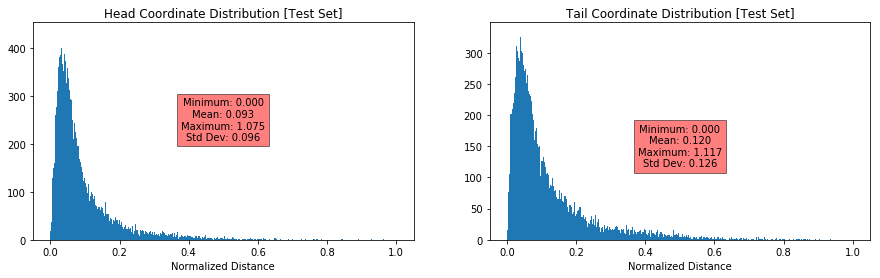

In [18]:
headEuclid = classMetrics['Dataset']['Euclid']['Distribution']['Head Distribution']
tailEuclid = classMetrics['Dataset']['Euclid']['Distribution']['Tail Distribution']
fig, axarr = plt.subplots(1,2, figsize=(15,4))
hn, hbins, hpatches = axarr[0].hist(headEuclid, 500, range=[0.0, 1.0])
axarr[0].set_xlabel('Normalized Distance')
axarr[0].set_title('Head Coordinate Distribution [Test Set]')
axarr[0].text(0.5,250, 'Minimum: {:0.3f}\nMean: {:0.3f}\nMaximum: {:0.3f}\nStd Dev: {:0.3f}'.format(headEuclid.min(), headEuclid.mean(),
              headEuclid.max(), np.std(headEuclid)),
              bbox=dict(facecolor='red', alpha=0.5),  horizontalalignment='center', verticalalignment='center')

tn, tbins, tpatches = axarr[1].hist(tailEuclid, 500, range=[0.0, 1.0])
axarr[1].set_xlabel('Normalized Distance')
axarr[1].set_title('Tail Coordinate Distribution [Test Set]')
axarr[1].text(0.5,150, 'Minimum: {:0.3f}\nMean: {:0.3f}\nMaximum: {:0.3f}\nStd Dev: {:0.3f}'.format(tailEuclid.min(), tailEuclid.mean(),
              tailEuclid.max(), np.std(tailEuclid)),
              bbox=dict(facecolor='red', alpha=0.5),  horizontalalignment='center', verticalalignment='center')
print 'Average Euclidian Distance: ', 0.5*(headEuclid.mean() + tailEuclid.mean())

# Class Evaluation

In [6]:
classMetrics, classMetrics_idx = {}, {}
lvl = 'Genus'
for cls in testTaxLvlDatasets[lvl]:
    # Gather images of each class by their indices from dataset
    trainIdx = [i for i, spc in enumerate(trainspecimenIDs) if spc in trainTaxLvlDatasets[lvl][cls]]
    testIdx = [i for i, spc in enumerate(testspecimenIDs) if spc in testTaxLvlDatasets[lvl][cls]]

    # Compute metrics
    metrics = {}
    metrics['Euclid'] = euclideanDistance (predCoordinates[testIdx], gtruthHead[testIdx], gtruthTail[testIdx])
    metrics['PoseVar'] = pose_variability2(poseTrainSet[trainIdx], [trainspecimenIDs[i] for i in trainIdx])
    metrics['KLDiv'] = pose_diff2(poseTrainSet[trainIdx], [trainspecimenIDs[i] for i in trainIdx],
                                       poseTestSet[testIdx], [testspecimenIDs[i] for i in testIdx])
    classMetrics[cls] = metrics
    classMetrics_idx[cls] = testIdx

utils/data.py:241: RuntimeWarning: invalid value encountered in divide
  prob = h / h.sum()


/home/plankton/miniconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


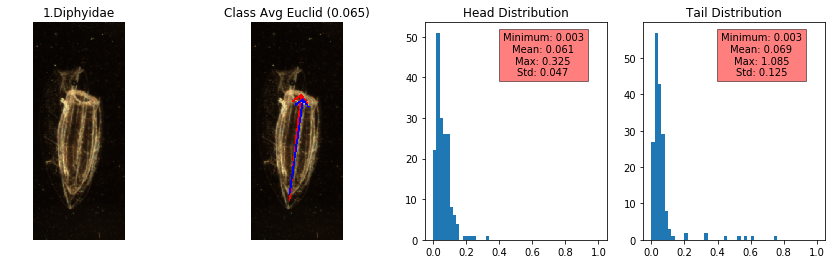

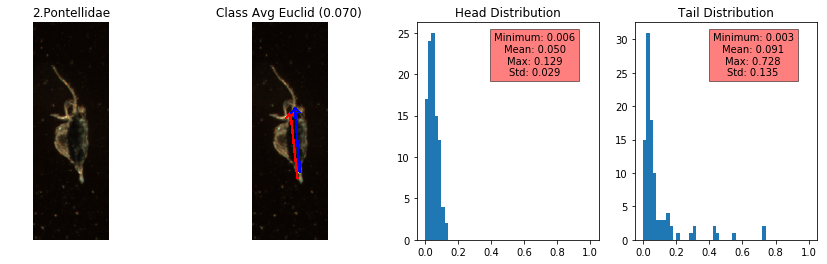

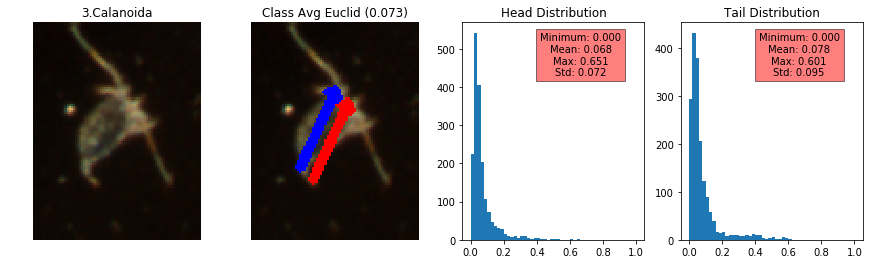

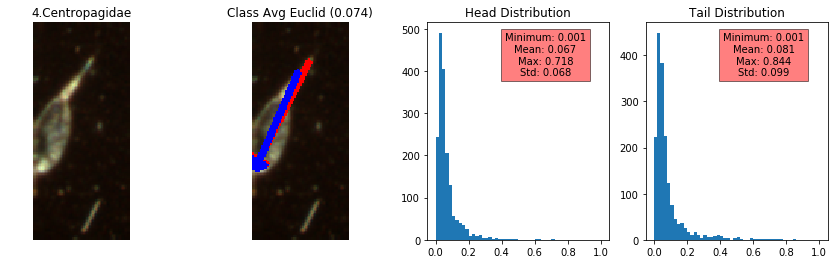

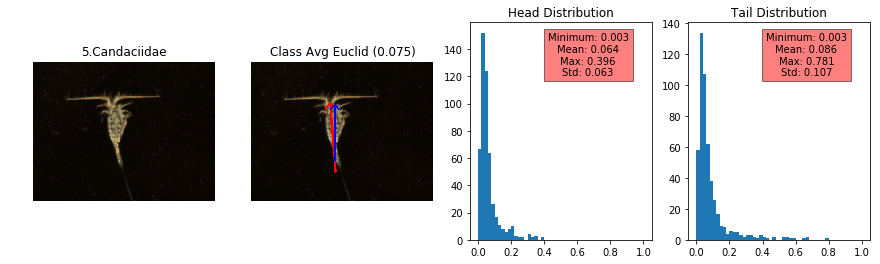

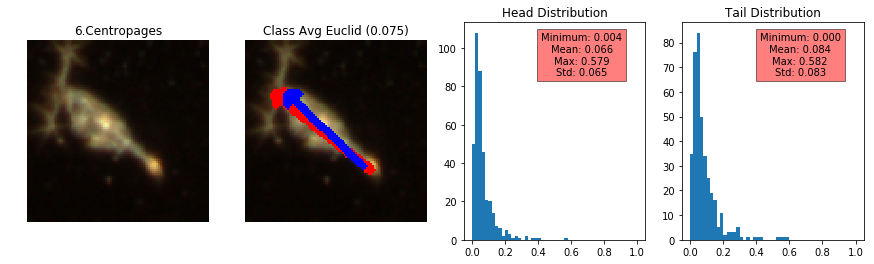

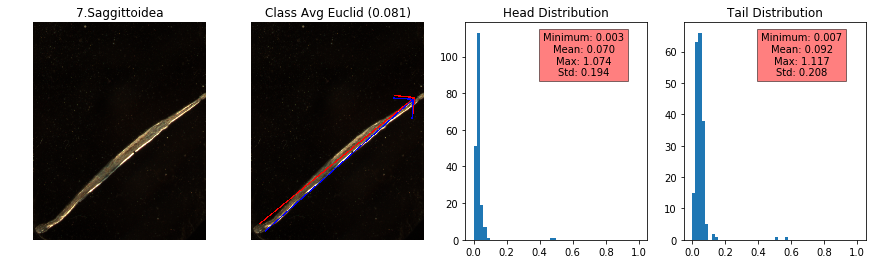

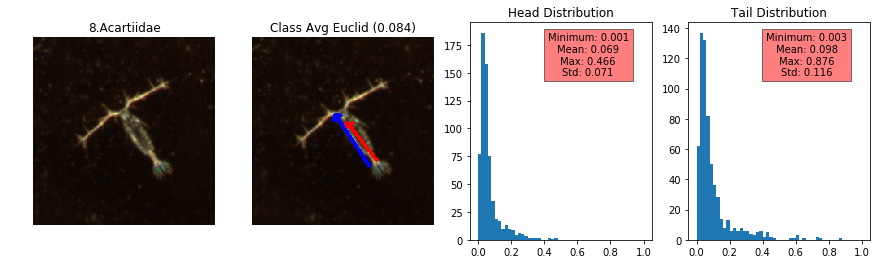

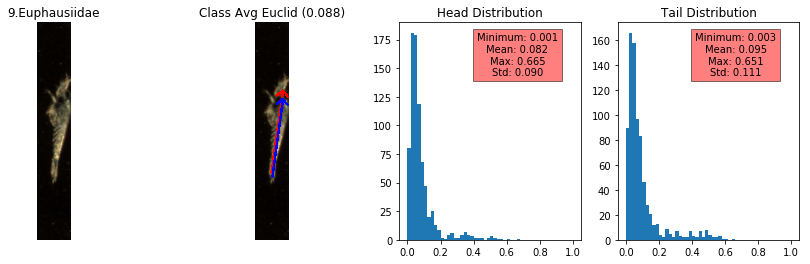

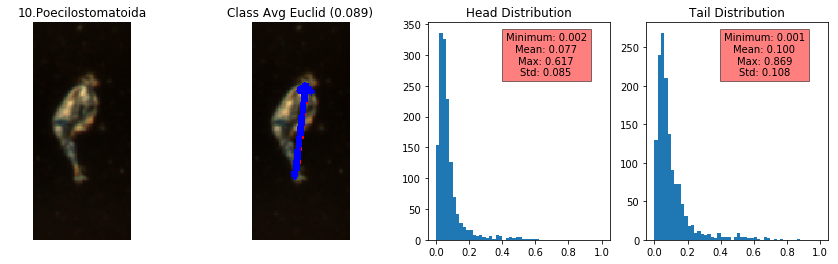

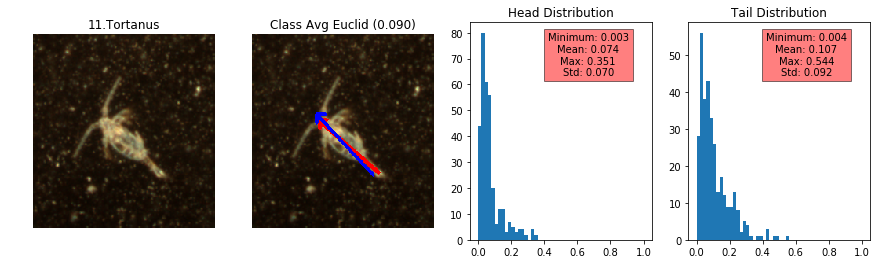

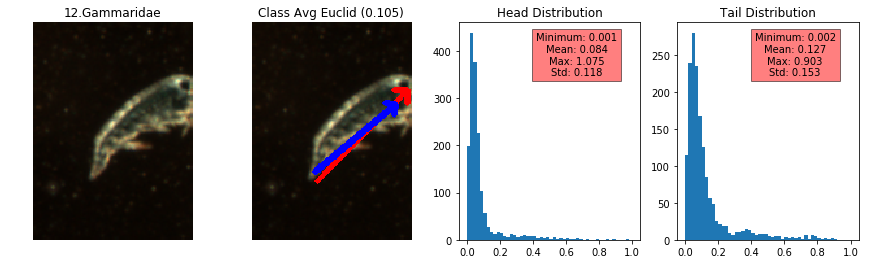

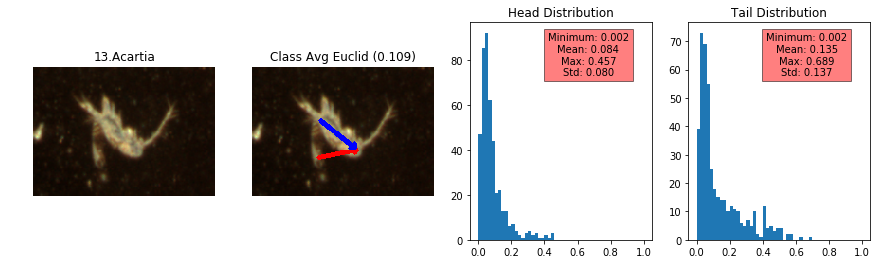

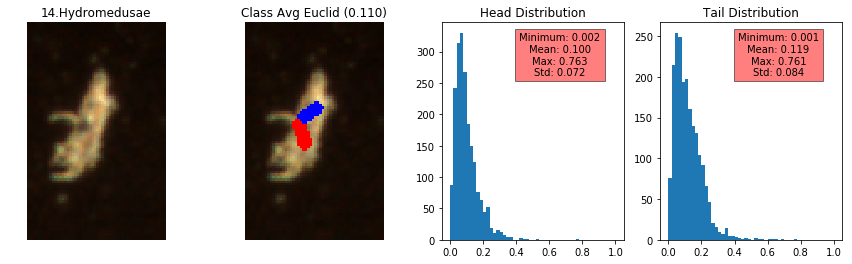

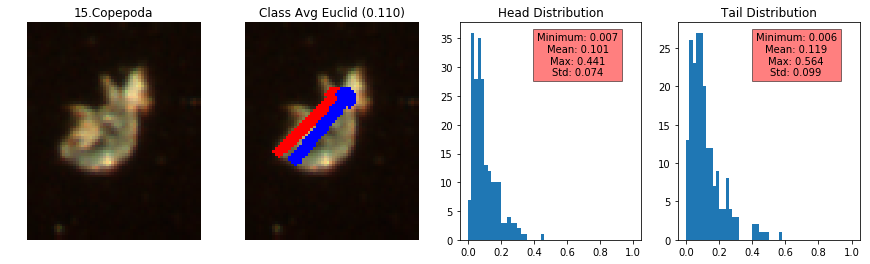

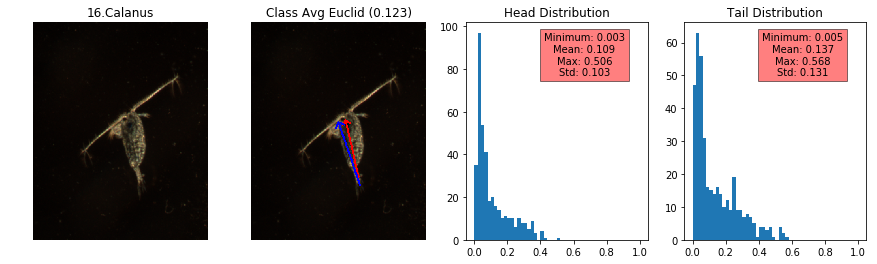

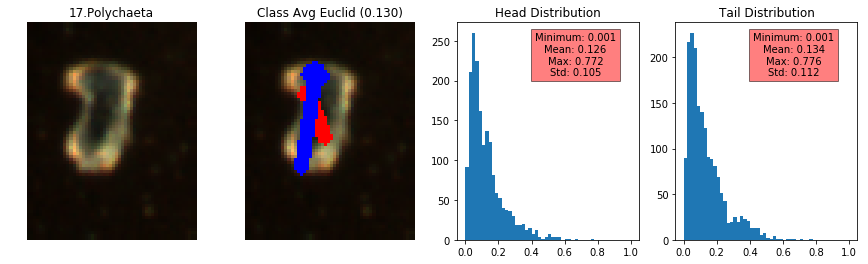

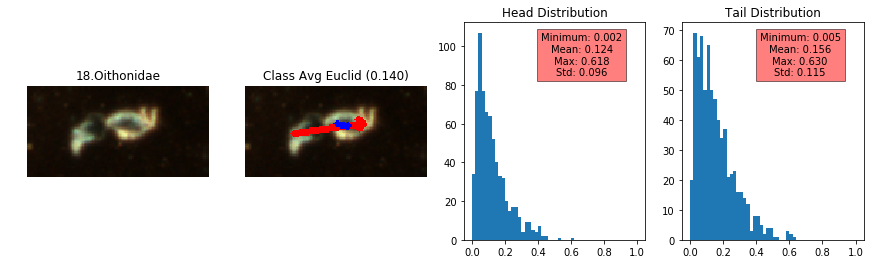

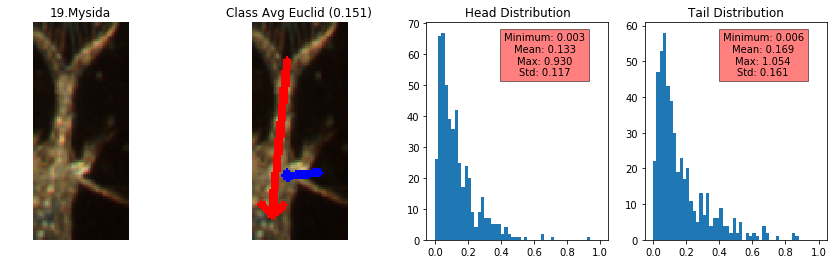

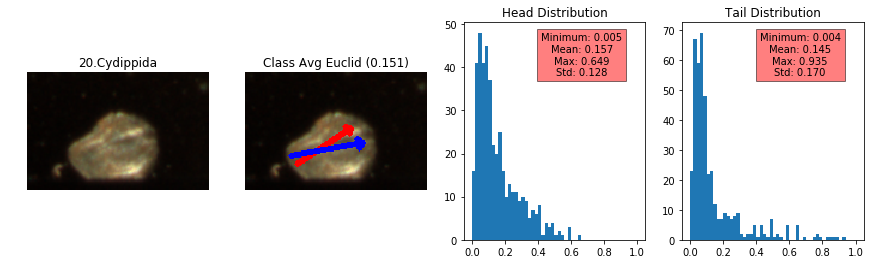

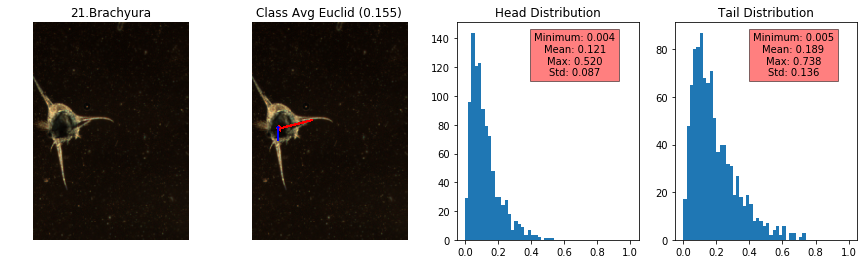

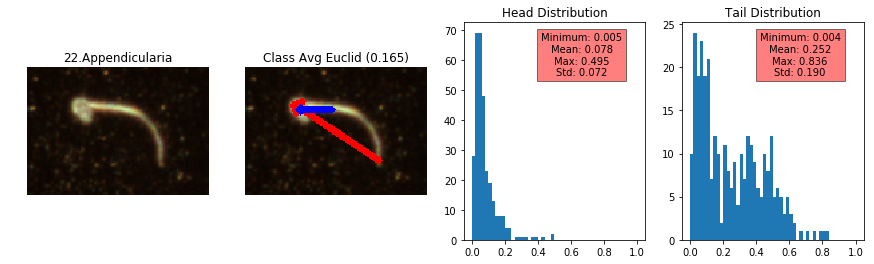

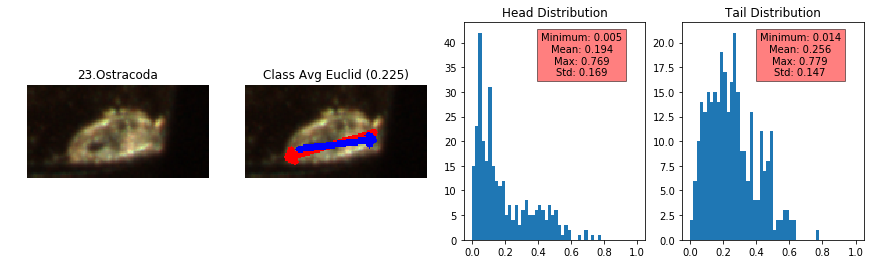

In [8]:
def plotEuclidDistribution(clsMetrics, clsMetIdx, dataset, predCoordinates):
    img_dir = '/data5/Plankton_wi18/rawcolor_db/images'
    numCols = 4
    histData = 3

    # Order classes
    classes = clsMetrics.keys()
    order = np.argsort([clsMetrics[cls]['Euclid']['Avg Distance'] for cls in classes])
    classes = [classes[i] for i in order]

    #plot Distributions
    for j,cls in enumerate(classes):
        fig, axarr = plt.subplots(1, numCols, figsize=(15,4))
        idx = clsMetIdx[cls][0] # image sample
        img = plt.imread(os.path.join(img_dir,dataset.data['images'][idx]))
        axarr[0].imshow(img)
        axarr[0].set_axis_off()
        axarr[0].set_title('{}.{}'.format(j+1, cls.split()[0]))
        
        headX, headY = dataset.data['head_x_rel'][idx], dataset.data['head_y_rel'][idx]
        tailX, tailY =  dataset.data['tail_x_rel'][idx], dataset.data['tail_y_rel'][idx]
        plotArrow(img, predCoordinates[idx], np.array([headX, headY, tailX, tailY]))
        axarr[1].imshow(img)
        axarr[1].set_axis_off()
        axarr[1].set_title('Class Avg Euclid ({:.03f})'.format(clsMetrics[cls]['Euclid']['Avg Distance']))
        for i,part in enumerate(clsMetrics[cls]['Euclid']['Distribution']):
            clsMin, clsMean, clsMax, clsStd = euclidStats(clsMetrics[cls]['Euclid']['Distribution'][part])
            axarr[i+2].hist(clsMetrics[cls]['Euclid']['Distribution'][part], 50, range=[0.0, 1.0])
            axarr[i+2].set_title(part)
            axarr[i+2].text(0.65,0.85, 'Minimum: {:0.3f}\nMean: {:0.3f}\nMax: {:0.3f}\nStd: {:0.3f}'.format(clsMin, clsMean, clsMax, clsStd), bbox=dict(facecolor='red', alpha=0.5),
                            horizontalalignment='center', verticalalignment='center', transform=axarr[i+2].transAxes)
    plt.show()
    
def plotArrow(image, predcoordinates, gtruthcoordinates):
    height, width = image.shape[:2]
    predhead = (int(predcoordinates[0,0] * width), int(predcoordinates[0,1]*height))
    predtail = (int(predcoordinates[1,0] * width), int(predcoordinates[1,1]*height))

    gtruthhead = (int(gtruthcoordinates[0] * width), int(gtruthcoordinates[1] * height))
    gtruthtail = (int(gtruthcoordinates[2] * width), int(gtruthcoordinates[3] * height))
    cv2.arrowedLine(image, gtruthtail, gtruthhead, (1., 0., 0.), 3) # gtruth
    cv2.arrowedLine (image, predtail, predhead, (0., 0., 1.), 3) # prediction

def euclidStats(histData):
    if not isinstance(histData, np.ndarray):
        histData = np.asarray(histData)
    return histData.min(), histData.mean(), histData.max(), np.std(histData)

plotEuclidDistribution(classMetrics, classMetrics_idx, datasets['test'], predCoordinates)

# Compare Pose Variability with Pose Prediction

In [5]:
classMetrics, classMetrics_idx = {}, {}
lvl = 'Species'
for cls in testTaxLvlDatasets[lvl]:
    # Gather images of each class by their indices from dataset
    trainIdx = [i for i, spc in enumerate(trainspecimenIDs) if spc in trainTaxLvlDatasets[lvl][cls]]
    testIdx = [i for i, spc in enumerate(testspecimenIDs) if spc in testTaxLvlDatasets[lvl][cls]]

    # Compute metrics
    metrics = {}
    metrics['Euclid'] = euclideanDistance (predCoordinates[testIdx], gtruthHead[testIdx], gtruthTail[testIdx])
    metrics['PoseVar'] = pose_variability2(poseTrainSet[trainIdx], [trainspecimenIDs[i] for i in trainIdx])
    metrics['KLDiv'] = pose_diff2(poseTrainSet[trainIdx], [trainspecimenIDs[i] for i in trainIdx],
                                       poseTestSet[testIdx], [testspecimenIDs[i] for i in testIdx])
    classMetrics[cls] = metrics
    classMetrics_idx[cls] = testIdx

utils/data.py:241: RuntimeWarning: invalid value encountered in divide
  prob = h / h.sum()


## Classes altogether

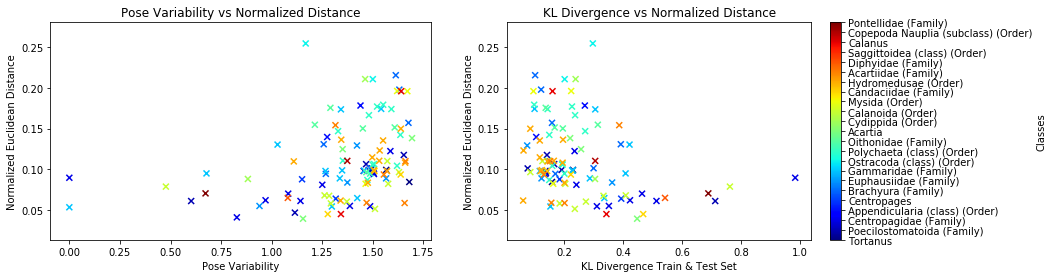

In [6]:
# organize speciesID by class and set them as a label
specimenIDs = classMetrics.keys()
planktonLbl = plankton_labels()
genus = [planktonLbl[spc][2] for spc in specimenIDs]
genusSet = {cls: {spc:classMetrics[spc] for spc in classMetrics if planktonLbl[spc][2] == cls} for cls in set(genus)}

avgEuclid = []; poseVar = []; label = []; kldiv = []
for dummyLbl,cls in enumerate(genusSet):
    avgEuclid += [genusSet[cls][spc]['Euclid']['Avg Distance'] for spc in genusSet[cls]]
    poseVar += [genusSet[cls][spc]['PoseVar'] for spc in genusSet[cls]]
    kldiv += [genusSet[cls][spc]['KLDiv'] for spc in genusSet[cls]]
    label += [dummyLbl for spc in genusSet[cls]]
    
N = len(label)
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,N,N+1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig, axarr = plt.subplots(1,2, figsize=(15,4))
scat = axarr[0].scatter(poseVar, avgEuclid, c=label, cmap=cmap, marker='x')
axarr[0].set_xlabel('Pose Variability'); axarr[0].set_ylabel('Normalized Euclidean Distance')
axarr[0].set_title('Pose Variability vs Normalized Distance')

scat1 = axarr[1].scatter(kldiv, avgEuclid, c=label, marker='x', cmap=cmap)
axarr[1].set_xlabel('KL Divergence Train & Test Set'); axarr[1].set_ylabel('Normalized Euclidean Distance')
axarr[1].set_title('KL Divergence vs Normalized Distance')
cb1 = plt.colorbar(scat1, spacing='proportional',ticks=bounds)
cb1.set_label('Classes')
cb1.set_ticklabels(genusSet.keys())

plt.show()

## Classes by themselves

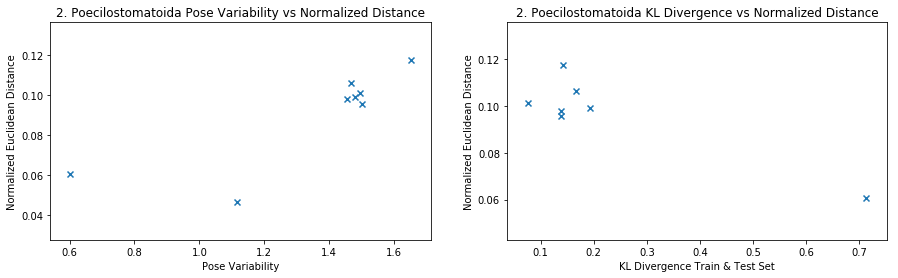

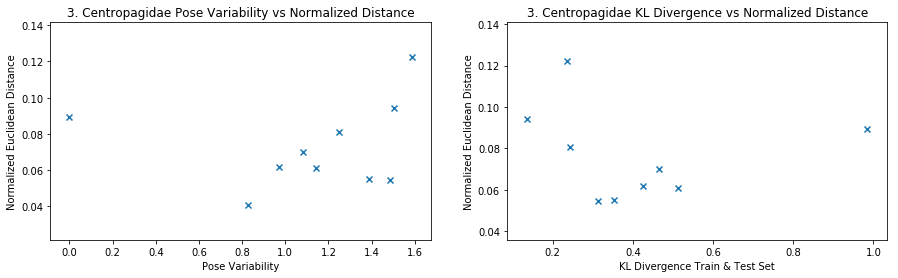

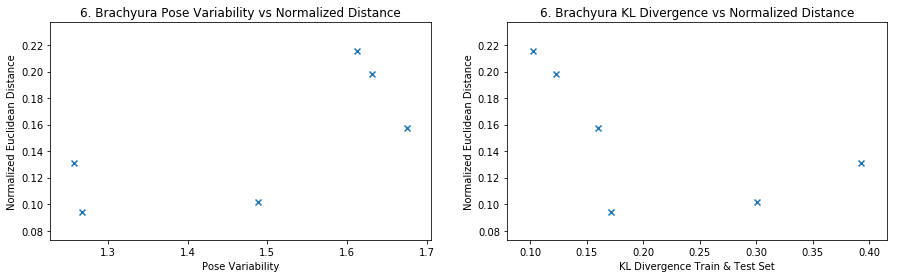

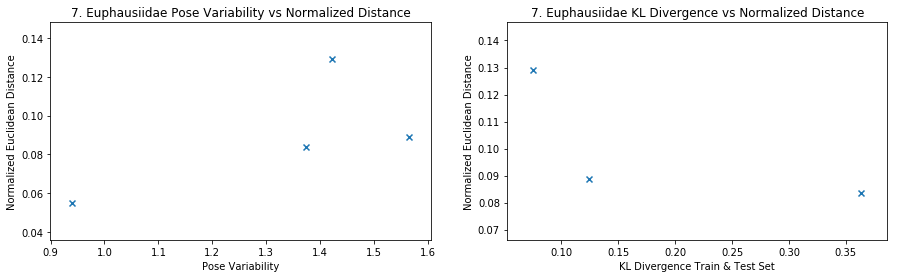

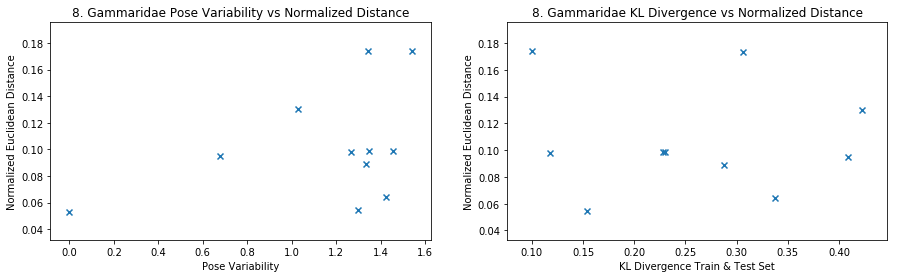

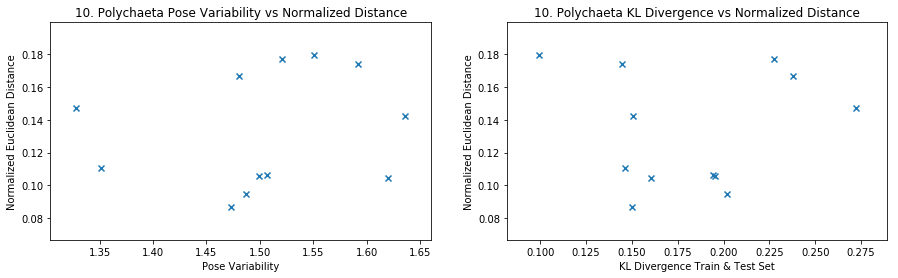

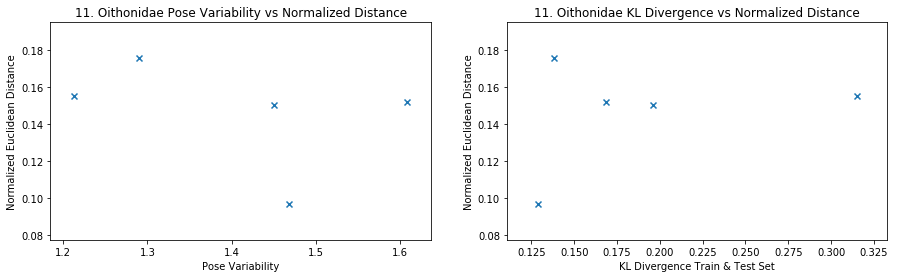

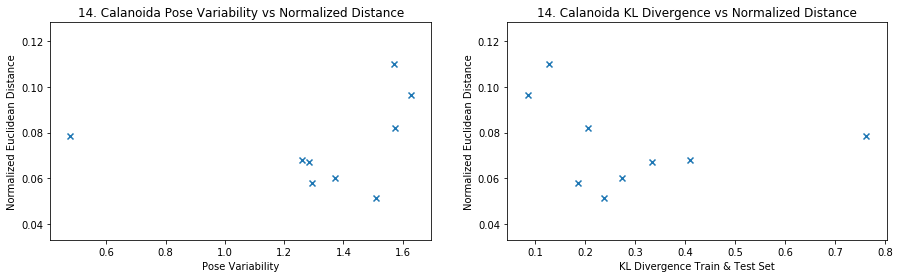

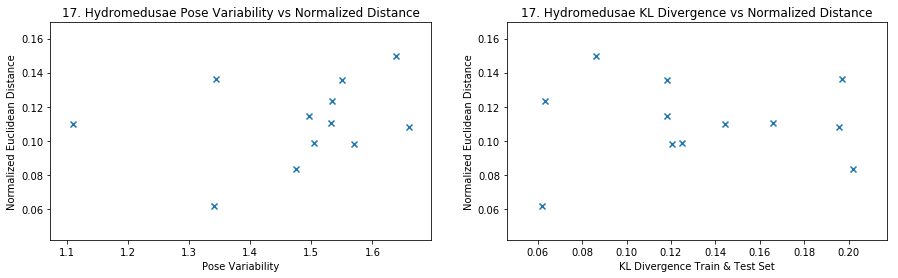

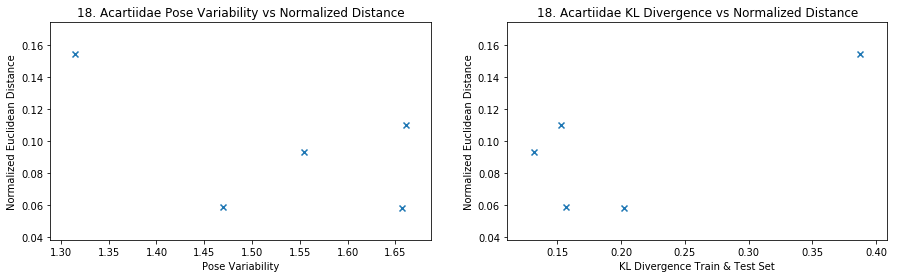

In [14]:
# organize speciesID by class and set them as a label
specimenIDs = classMetrics.keys()
planktonLbl = plankton_labels()
genus = [planktonLbl[spc][2] for spc in specimenIDs]
genusSet = {cls: {spc:classMetrics[spc] for spc in classMetrics if planktonLbl[spc][2] == cls} for cls in set(genus)}

for i,cls in enumerate(genusSet):
    avgEuclid = [genusSet[cls][spc]['Euclid']['Avg Distance'] for spc in genusSet[cls]]
    poseVar = [genusSet[cls][spc]['PoseVar'] for spc in genusSet[cls]]
    kldiv = [genusSet[cls][spc]['KLDiv'] for spc in genusSet[cls]]
    
    if len(poseVar) > 3 or len(kldiv) > 3:
        fig, axarr = plt.subplots(1,2, figsize=(15,4))
        axarr[0].scatter(poseVar, avgEuclid, marker='x')
        axarr[0].set_xlabel('Pose Variability'); axarr[0].set_ylabel('Normalized Euclidean Distance')
        axarr[0].set_title('{}. {} Pose Variability vs Normalized Distance'.format(i+1, cls.split()[0]))

        axarr[1].scatter(kldiv, avgEuclid, marker='x')
        axarr[1].set_xlabel('KL Divergence Train & Test Set'); axarr[1].set_ylabel('Normalized Euclidean Distance')
        axarr[1].set_title('{}. {} KL Divergence vs Normalized Distance'.format(i+1, cls.split()[0]))
        plt.show()